In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns
import pickle
import os
import sys

In [3]:
#Ignoring Warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from logger import Logger

In [5]:
# Initialize logger
logger = Logger("userSatisfaction.log").get_app_logger()
logger.info("Initialized user satisfaction logger")

In [6]:
pl = Plot()

In [7]:
#reading the cleaned data in EDA
df_org = pd.read_csv("C:\\Users\\1221\\Desktop\\Telecommunication-Data\\data\\cleaned telecom data.csv")
df = df_org.copy()

Satisfaction Analysis

In [8]:
# Import user experience data
user_exp = pd.read_csv('../data/user_exp.csv')

# Import user engagement data
user_eng = pd.read_csv('../data/user_eng.csv')

In [9]:
user_exp.head()

,MSISDN/Number,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total
0,-0.002692,1,0.024925,0.055505,0.103643
1,-0.002692,1,0.024834,0.055524,0.103643
2,-0.002692,1,0.026789,0.055522,0.103643
3,-0.002692,1,0.026209,0.055555,0.103153
4,-0.002692,0,0.023633,0.081818,0.103244


In [10]:
user_eng.head()

,MSISDN/Number,cluster,sessions,Dur. (ms).1,total_data
0,-0.002692,2,1,0.146799,1.139608
1,-0.002692,1,1,0.944041,-1.812243
2,-0.002692,0,1,0.372328,0.256948
3,-0.002692,1,1,-0.679254,-2.059544
4,-0.002692,2,2,-2.132773,2.926302


In [11]:
with open("../models/user_eng.pkl", "rb") as f:
    kmeans1 = pickle.load(f)
    
with open("../models/user_exp.pkl", "rb") as f:
    kmeans2 = pickle.load(f)

Calculating distance between centroids

In [12]:
user_eng_df = user_eng.set_index('MSISDN/Number')[
    ['sessions','Dur. (ms).1', 'total_data']]
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_eng_df)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.232540,0.076622,0.680985
1,-0.232540,0.492745,-1.082925
2,-0.232540,0.194338,0.153542
3,-0.232540,-0.354539,-1.230702
4,0.359739,-1.113207,1.748642


In [13]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.321338,0.105881,0.941027
1,-0.191822,0.406465,-0.893303
2,-0.684482,0.572034,0.451952
3,-0.178644,-0.272368,-0.945464
4,0.170987,-0.529116,0.831143


Calculate Engagement and Experience Scores

In [14]:
distance = kmeans1.fit_transform(data_normalized)
distance_from_less_engagement = list(
    map(lambda x: x[3], distance))
user_eng['engagement_score'] = distance_from_less_engagement
user_eng.head(5)

,MSISDN/Number,cluster,sessions,Dur. (ms).1,total_data,engagement_score
0,-0.002692,2,1,0.146799,1.139608,1.171339
1,-0.002692,1,1,0.944041,-1.812243,1.018048
2,-0.002692,0,1,0.372328,0.256948,0.565240
3,-0.002692,1,1,-0.679254,-2.059544,1.466451
4,-0.002692,2,2,-2.132773,2.926302,1.679832


In [15]:
len(user_exp)

106294

In [16]:
exp_df = user_exp.set_index('MSISDN/Number')
distance = kmeans2.fit_transform(data_normalized)
distance_from_worest_experiance = list(
    map(lambda x: x[0], distance))
user_exp['experience_score'] = distance_from_worest_experiance
user_exp.head(5)

,MSISDN/Number,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score
0,-0.002692,1,0.024925,0.055505,0.103643,1.135669
1,-0.002692,1,0.024834,0.055524,0.103643,0.970135
2,-0.002692,1,0.026789,0.055522,0.103643,0.708180
3,-0.002692,1,0.026209,0.055555,0.103153,1.398297
4,-0.002692,0,0.023633,0.081818,0.103244,1.545116


Consider the average of both engagement & experience scores as the satisfaction score & report the top 10 satisfied customer

In [17]:
user_eng_id = user_eng['MSISDN/Number'].values
user_exp_id = user_exp['MSISDN/Number'].values
user_intersection = list(
    set(user_eng_id).intersection(user_exp_id))
user_intersection[:5]

[0.0,
 -0.0026115922481722,
 -0.0026374045086186,
 -0.0026231732965698,
 -0.0026579428547393]

In [18]:
user_eng_df = user_eng[user_eng['MSISDN/Number'].isin(
    user_intersection)]

user_eng_df.shape

(106294, 6)

In [19]:
user_expe_df = user_exp[user_exp['MSISDN/Number'].isin(
    user_intersection)]

user_expe_df.shape

(106294, 6)

Calulate the satisfaction score for each customer based on engagement & experience score

In [20]:
user_df = pd.merge(user_eng_df, user_exp, on='MSISDN/Number')
user_df['satisfaction_score'] = (
    user_df['engagement_score'] + user_df['experience_score'])/2
user_df.head(5)

,MSISDN/Number,cluster_x,sessions,Dur. (ms).1,total_data,engagement_score,cluster_y,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score,satisfaction_score
0,-0.002692,2,1,0.146799,1.139608,1.171339,1,0.024925,0.055505,0.103643,1.135669,1.153504
1,-0.002692,1,1,0.944041,-1.812243,1.018048,1,0.024834,0.055524,0.103643,0.970135,0.994092
2,-0.002692,0,1,0.372328,0.256948,0.565240,1,0.026789,0.055522,0.103643,0.708180,0.636710
3,-0.002692,1,1,-0.679254,-2.059544,1.466451,1,0.026209,0.055555,0.103153,1.398297,1.432374
4,-0.002692,2,2,-2.132773,2.926302,1.679832,0,0.023633,0.081818,0.103244,1.545116,1.612474


In [21]:
satisfaction_df = user_df[['MSISDN/Number', 'engagement_score',
                        'experience_score', 'satisfaction_score']]
satisfaction_df = satisfaction_df.set_index('MSISDN/Number')

In [22]:
top_10_satisfaction = satisfaction_df.nlargest(10, 'satisfaction_score')
top_10_satisfaction.head(10)

,engagement_score,experience_score,satisfaction_score
MSISDN/Number,,,
-0.002509,1.911084,1.753999,1.832541
-0.002665,1.911402,1.753670,1.832536
-0.002581,1.910976,1.754090,1.832533
-0.002623,1.911369,1.753692,1.832530
-0.002637,1.911232,1.753819,1.832525
-0.002639,1.910573,1.754477,1.832525
-0.002641,1.910718,1.754324,1.832521
-0.002664,1.911513,1.753509,1.832511
-0.002613,1.911886,1.753114,1.832500


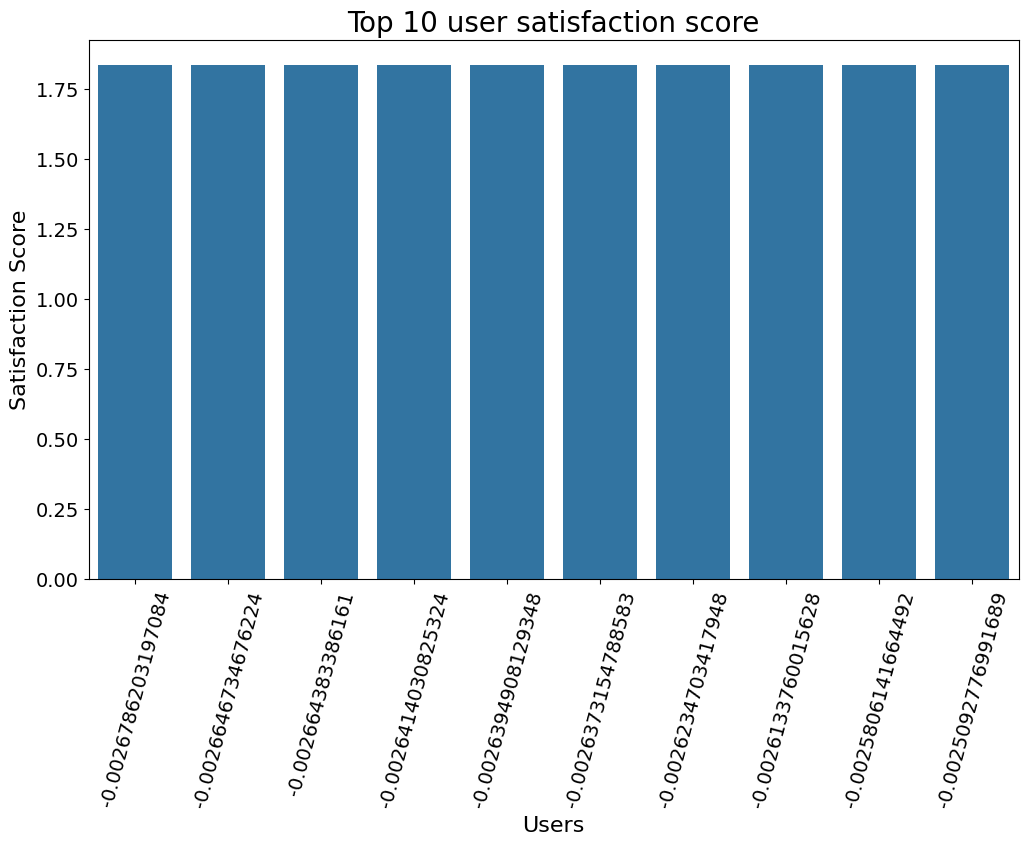

In [23]:
pl.plot_bar(top_10_satisfaction, top_10_satisfaction.index, top_10_satisfaction['satisfaction_score'],
             "Top 10 user satisfaction score", 
            "Users", "Satisfaction Score")

Build a regression model of your choice to predict the satisfaction score of a customer.

In [24]:
class Model:
    def __init__(self,X_train,X_test,y_train,y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test


    def model(self):
        self.trained_model = LinearRegression()
        self.trained_model.fit(self.X_train, self.y_train)
        

    def predict(self):
        self.model()
        return self.trained_model.predict(self.X_test)

    def score(self):
        return self.trained_model.score(self.X_test, self.y_test)

    def error_score(self):
        return np.mean((self.trained_model.predict(self.X_test) - self.y_test) ** 2)
    
    def save_model(self, path):
        pickle.dump(self.trained_model, open(path, 'wb'))

Take X as the engagement score, engagement score and y as the satisfaction score.

In [25]:
X = satisfaction_df[['engagement_score', 'experience_score']]
Y = satisfaction_df[['satisfaction_score']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42) 

In [26]:
model = Model(X_train, X_test, y_train, y_test)
model.predict()

array([[1.57239728],
       [1.61077638],
       [1.42125841],
       ...,
       [1.32737214],
       [1.31267132],
       [1.34651664]])

In [27]:
model.score()

1.0

In [28]:
model.error_score()

6.909275260877704e-32

In [29]:
model.save_model("../models/satisfaction_model.pkl")

Run a k-means (k=2) on the engagement & the experience score 

In [30]:
user_df.head()

,MSISDN/Number,cluster_x,sessions,Dur. (ms).1,total_data,engagement_score,cluster_y,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score,satisfaction_score
0,-0.002692,2,1,0.146799,1.139608,1.171339,1,0.024925,0.055505,0.103643,1.135669,1.153504
1,-0.002692,1,1,0.944041,-1.812243,1.018048,1,0.024834,0.055524,0.103643,0.970135,0.994092
2,-0.002692,0,1,0.372328,0.256948,0.565240,1,0.026789,0.055522,0.103643,0.708180,0.636710
3,-0.002692,1,1,-0.679254,-2.059544,1.466451,1,0.026209,0.055555,0.103153,1.398297,1.432374
4,-0.002692,2,2,-2.132773,2.926302,1.679832,0,0.023633,0.081818,0.103244,1.545116,1.612474


In [31]:
user_satisfaction_df = user_df[[
    'MSISDN/Number', 
    'engagement_score',
    'experience_score']]
user_satisfaction_df = user_satisfaction_df.set_index('MSISDN/Number')

user_satisfaction_df.head()

,engagement_score,experience_score
MSISDN/Number,,
-0.002692,1.171339,1.135669
-0.002692,1.018048,0.970135
-0.002692,0.565240,0.708180
-0.002692,1.466451,1.398297
-0.002692,1.679832,1.545116


scale the data & normalize the data for clustering

In [32]:
from sklearn.preprocessing import Normalizer

def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

user_satisfaction_df

,engagement_score,experience_score
MSISDN/Number,,
-0.002692,1.171339,1.135669
-0.002692,1.018048,0.970135
-0.002692,0.565240,0.708180
-0.002692,1.466451,1.398297
-0.002692,1.679832,1.545116
...,...,...
-0.002476,1.570556,1.345472
-0.002476,1.737095,1.678153
-0.002476,0.762935,0.820964


In [33]:
normalized_df = normalizer(user_satisfaction_df, ['engagement_score', 'experience_score'] )

In [34]:
normalized_sat_df = normalized_df.copy()

In [35]:
kmeans = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_sat_df)
centroids = kmeans.cluster_centers_

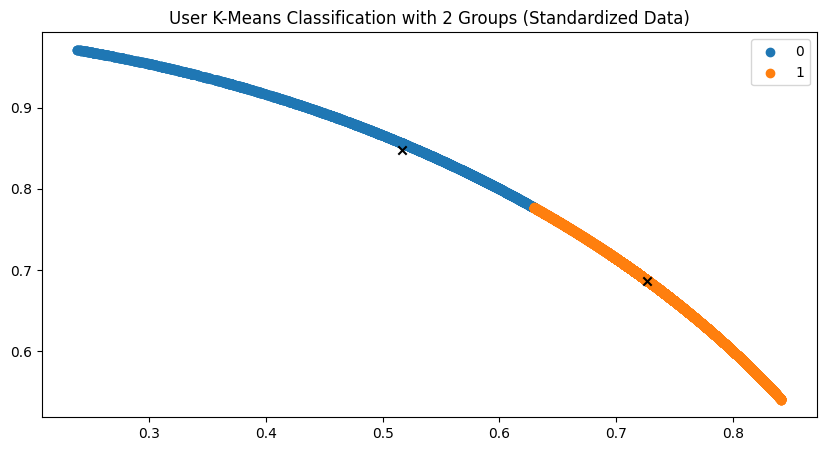

In [36]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 2 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_sat_df[label == i].iloc[:,0] , normalized_sat_df[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1], marker='x', color = 'black')
plt.legend()
plt.show()

In [37]:
normalized_sat_df.head()

,engagement_score,experience_score
0,0.717954,0.696091
1,0.723937,0.689866
2,0.623817,0.781570
3,0.723724,0.690089
4,0.736003,0.676978


In [38]:
u_sat_eng = user_satisfaction_df.copy()

In [39]:
u_sat_eng.insert(0, 'cluster', kmeans.labels_)
u_sat_eng.head(5)

,cluster,engagement_score,experience_score
MSISDN/Number,,,
-0.002692,1,1.171339,1.135669
-0.002692,1,1.018048,0.970135
-0.002692,0,0.565240,0.708180
-0.002692,1,1.466451,1.398297
-0.002692,1,1.679832,1.545116


Save the data

In [40]:
u_sat_eng.to_csv('../data/user_satisfaction.csv')

Aggregate the average satisfaction & experience score per cluster.

In [41]:
agg_sat = u_sat_eng.groupby('cluster').agg(
    {'engagement_score': 'sum', 'experience_score': 'sum'})

In [42]:
agg_sat_df = pd.DataFrame()
agg_sat_df['cluster'] = agg_sat.index
agg_sat_df['engagement_score'] = agg_sat['engagement_score']
agg_sat_df['experience_score'] = agg_sat['experience_score']

In [43]:
agg_sat_df.head()

,cluster,engagement_score,experience_score
0,0,1126.466101,1746.399995
1,1,137162.493332,129561.939895


<Axes: xlabel='cluster', ylabel='engagement_score'>

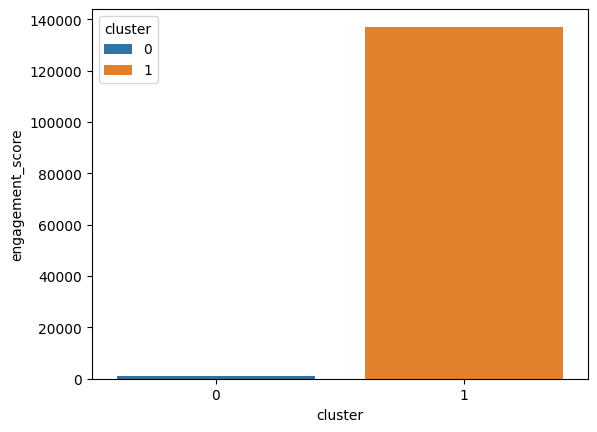

In [44]:
sns.barplot(x="cluster", y="engagement_score", hue="cluster", data=agg_sat_df)

Export your final table containing all user id + engagement, experience & satisfaction scores in your local MySQL database. Report a screenshot of a select query output on the exported table.

Add to postgresql database

In [47]:
from sqlalchemy import create_engine

# Create SQLAlchemy engine for PostgreSQL
engine = create_engine('postgresql://postgres:passwardlocalhost:5432/telecom')

# Connect using psycopg2
try:
    conn = psycopg2.connect(
        database='telecom', user='postgres', password='passward', host='localhost', port=5432
    )
    cursor = conn.cursor()
    cursor.execute("SELECT version()")
    data = cursor.fetchone()
    print("Connection established to: ", data)

    # Upload the DataFrame to the SQL database
    agg_sat_df.to_sql('user_satisfaction', engine, if_exists='replace', index=False)

except (Exception, psycopg2.Error) as error:
    print("Error: ", error)
finally:
    if conn:
        cursor.close()
        conn.close()

Connection established to:  ('PostgreSQL 16.4, compiled by Visual C++ build 1940, 64-bit',)
Error:  (psycopg2.OperationalError) could not translate host name "607625@localhost" to address: A non-recoverable error occurred during a database lookup. 

(Background on this error at: https://sqlalche.me/e/20/e3q8)
